In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import callbacks
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Model Config

In [2]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-5

# final embedding and transformer embedding size
UNITS_ENCODER = 384
UNITS_DECODER = 384

# Transformer
NUM_BLOCKS_ENCODER = 3
NUM_BLOCKS_DECODER = 2
NUM_HEADS = 4
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.2
MLP_DROPOUT_RATIO = 0.2
MHA_DROPOUT_RATIO = 0.2
CLASSIFIER_DROPOUT_RATIO = 0.2

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

# Max Learning Rate
LEARNING_RATE = 1e-4

# Number of time frames
MAX_FRAMES = 128

# Length of output + EOS Token
MAX_OUTPUT_SEQUENCE_LENGTH = 31 + 1

# Original number of classes
OUTPUT_CLASSES0 = 59

# PAD Token
PAD_TOKEN = OUTPUT_CLASSES0

# SOS TOEKN
SOS_TOKEN =  OUTPUT_CLASSES0 + 1

# EOS Token
EOS_TOKEN = OUTPUT_CLASSES0 + 2

# Possible Output classes
OUTPUT_CLASSES = OUTPUT_CLASSES0 +  3 # with pad, sos, and eos tokens

In [3]:
FEATURE_DIM = 164 # Feature dimension

In [4]:
MEANS = 0 # Important to change to real value
STDS = 0 # Important to change to real value

# Feature Embedding


In [5]:
# Embeds a feature using fully connected layers
class FeatureEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(FeatureEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        self.supports_masking = True

    def build(self, input_shape):
        # Embedding for missing feature in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU), # Can change initializer/activation
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense') # Can change initializer/activation

    def call(self, x):
        return tf.where(
                # Checks whether feature is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the feature data is embedded
                self.dense(x),
            )
        # Note that not all transformers need to have the empty embedding.

# Final Embedding with Positional Embedding

In [6]:
# Creates embedding for each frame
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        self.supports_masking = True

    def build(self, input_shape):
        # Positional embedding for each frame index
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([MAX_FRAMES, UNITS_ENCODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Embedding layer for Features
        self.feature_embedding = FeatureEmbedding(UNITS_ENCODER, 'feature')

    def call(self, x, training=False):
        # Normalize
        x = tf.where(
                tf.math.equal(x, 0.0),
                0.0,
                (x - MEANS) / STDS,
            )
        # Dominant Hand
        x = self.feature_embedding(x)
        # Add Positional Encoding
        x = x + self.positional_embedding

        return x

# MultiHead Attention Block

In [7]:
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model, num_of_heads, dropout, d_out=None):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model // num_of_heads # Can change
        self.wq = [tf.keras.layers.Dense(self.depth//2, use_bias=False) for i in range(num_of_heads)] # depth//2 isn't common, we can try different numbers
        self.wk = [tf.keras.layers.Dense(self.depth//2, use_bias=False) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth//2, use_bias=False) for i in range(num_of_heads)]
        self.softmax = tf.keras.layers.Softmax()
        self.do = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True
        self.wo = tf.keras.layers.Dense(d_model if d_out is None else d_out, use_bias=False)

    def call(self, q, k, v, attention_mask=None, training=False):

        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](q)
            K = self.wk[i](k)
            V = self.wv[i](v)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))

        multi_head = tf.concat(multi_attn, axis=-1)
        multi_head_attention = self.wo(multi_head)
        multi_head_attention = self.do(multi_head_attention, training=training)

        return multi_head_attention

# Transformer Block

In [8]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, units, num_heads, mlp_ratio, mha_dropout_ratio, mlp_dropout_ratio, is_decoder=False, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.is_decoder = is_decoder # Checks if decoder
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.mha = MultiHeadAttention(units, num_heads, mha_dropout_ratio)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(units * mlp_ratio, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
            tf.keras.layers.Dropout(mlp_dropout_ratio),
            tf.keras.layers.Dense(units, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
        ])

    def call(self, inputs, attention_mask, encoder_outputs=None, training=False):
        if self.is_decoder:
            assert encoder_outputs is not None # decoder must get output from encoder
            x = self.layer_norm_1(inputs + self.mha(inputs, encoder_outputs, encoder_outputs, attention_mask=attention_mask))
        else:
            x = self.layer_norm_1(inputs + self.mha(inputs, inputs, inputs, attention_mask=attention_mask))

        x = self.layer_norm_2(x + self.mlp(x))
        return x


# Encoder

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Encoder, self).__init__(name='encoder')
        self.num_blocks = num_blocks
        self.support_masking = True
        self.blocks = [TransformerBlock(UNITS_ENCODER, NUM_HEADS, MLP_RATIO, MHA_DROPOUT_RATIO, MLP_DROPOUT_RATIO) for _ in range(num_blocks)]

        # Optional Projection to Decoder Dimension
        if UNITS_ENCODER != UNITS_DECODER:
            self.dense_out = tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False)
            self.apply_dense_out = True
        else:
            self.apply_dense_out = False

    def call(self, x, x_inp, training=False):
        # Attention mask to ignore missing frames
        attention_mask = tf.where(tf.math.reduce_sum(x_inp, axis=[2]) == 0.0, 0.0, 1.0)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.repeat(attention_mask, repeats=MAX_FRAMES, axis=1)

        # Iterate input over transformer blocks
        for block in self.blocks:
            x = block(x, attention_mask=attention_mask, training=training)

        # Optional Projection to Decoder Dimension
        if self.apply_dense_out:
            x = self.dense_out(x)

        return x, attention_mask


# Decoder

In [10]:
class Decoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Decoder, self).__init__(name='decoder')
        self.num_blocks = num_blocks
        self.supports_masking = True

        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([MAX_FRAMES, UNITS_DECODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )

        # Character Embedding
        self.char_emb = tf.keras.layers.Embedding(OUTPUT_CLASSES, UNITS_DECODER, embeddings_initializer=INIT_ZEROS)

        # Positional Encoder MHA
        self.pos_emb_mha = MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO)
        self.pos_emb_ln = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

        # Transformer Blocks
        self.blocks = [TransformerBlock(UNITS_DECODER, NUM_HEADS, MLP_RATIO, MHA_DROPOUT_RATIO,MLP_DROPOUT_RATIO, is_decoder=True) for _ in range(num_blocks)]

    def get_causal_attention_mask(self, B):
        # My version of the mask AM
        ones = tf.ones((MAX_FRAMES, MAX_FRAMES))
        mask = tf.linalg.band_part(ones, 0, -1)
        mask = tf.transpose(mask)
        mask = tf.expand_dims(mask, axis=0)
        mask = tf.tile(mask, [B, 1, 1])
        mask = tf.cast(mask, tf.float32)
        return mask

    def call(self, encoder_outputs, attention_mask, y, training=False):
        # Batch Size
        B = tf.shape(encoder_outputs)[0]
        # Cast to INT32
        y = tf.cast(y, tf.int32)
        # Prepend SOS Token
        y = tf.pad(y, [[0,0], [1,0]], constant_values=SOS_TOKEN, name='prepend_sos_token')
        # Pad With PAD Token
        y = tf.pad(y, [[0,0], [0,MAX_FRAMES-MAX_OUTPUT_SEQUENCE_LENGTH-1]], constant_values=PAD_TOKEN, name='append_pad_token')
        # Causal Mask
        causal_mask = self.get_causal_attention_mask(B)
        # Positional Embedding
        x = self.positional_embedding + self.char_emb(y)
        # Causal Attention
        x = self.pos_emb_ln(x + self.pos_emb_mha(x, x, x, attention_mask=causal_mask))
        # Iterate input over causal_masktransformer blocks
        for block in self.blocks:
            x = block(x, attention_mask=attention_mask, encoder_outputs=encoder_outputs, training=training)
        # Slice
        x = tf.slice(x, [0, 0, 0], [-1, MAX_OUTPUT_SEQUENCE_LENGTH, -1])
        return x


# Non Pad/SOS/EOS Token Accuracy

In [11]:
# TopK accuracy for multi dimensional output
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k, **kwargs):
        super(TopKAccuracy, self).__init__(name=f'top{k}acc', **kwargs)
        self.top_k_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, OUTPUT_CLASSES])
        character_idxs = tf.where(y_true < OUTPUT_CLASSES0)
        y_true = tf.gather(y_true, character_idxs, axis=0)
        y_pred = tf.gather(y_pred, character_idxs, axis=0)
        self.top_k_acc.update_state(y_true, y_pred)

    def result(self):
        return self.top_k_acc.result()

    def reset_state(self):
        self.top_k_acc.reset_state()

# Sparse Categorical Crossentropy With Label Smoothing

In [12]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy

class CustomSCCEWithLS(tf.keras.losses.Loss):
    def __init__(self, loss_weights, pad_token=PAD_TOKEN, output_classes=OUTPUT_CLASSES, label_smoothing=0.25, **kwargs):
        super().__init__(**kwargs)
        self.loss_weights = loss_weights
        self.pad_token = pad_token
        self.output_classes = output_classes
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        # Filter Pad Tokens
        idxs = tf.where(y_true != self.pad_token)
        y_true = tf.gather_nd(y_true, idxs)
        y_pred = tf.gather_nd(y_pred, idxs)
        # One Hot Encode Sparsely Encoded Target Sign
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, self.output_classes, axis=1)
        # Apply loss_weights
        y_true = y_true * self.loss_weights
        # Categorical Crossentropy with native label smoothing support
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=self.label_smoothing, from_logits=True)
        loss = tf.math.reduce_mean(loss)
        return loss

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "loss_weights": self.loss_weights.tolist(), "pad_token": self.pad_token,
                "output_classes": self.output_classes, "label_smoothing": self.label_smoothing}


# Model

In [13]:
def get_model():
    # Inputs
    frames_inp = tf.keras.layers.Input([MAX_FRAMES, FEATURE_DIM], dtype=tf.float32, name='frames')
    phrase_inp = tf.keras.layers.Input([MAX_OUTPUT_SEQUENCE_LENGTH], dtype=tf.int32, name='phrase')
    # Frames
    x = frames_inp

    # Masking
    x = tf.keras.layers.Masking(mask_value=0.0, input_shape=(MAX_FRAMES, FEATURE_DIM))(x)

    # Embedding
    x = Embedding()(x)

    # Encoder Transformer Blocks
    x, attention_mask = Encoder(NUM_BLOCKS_ENCODER)(x, frames_inp)

    # Decoder
    x = Decoder(NUM_BLOCKS_DECODER)(x, attention_mask, phrase_inp)

    # Classifier
    x = tf.keras.Sequential([
        # Dropout
        tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO),
        # Output Neurons
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation=tf.keras.activations.linear, kernel_initializer=INIT_HE_UNIFORM, use_bias=False), # can changes initializer/activation
    ], name='classifier')(x)

    outputs = x

    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames_inp, phrase_inp], outputs=outputs)

    #optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # We should try different optimizers with learning rate scheduler

    # Create Initial Loss Weights All Set To 1
    loss_weights_tensor = tf.ones([OUTPUT_CLASSES], dtype=tf.float32)
    # Set Loss Weight Of Pad Token To 0
    loss_weights_tensor = tf.tensor_scatter_nd_update(loss_weights_tensor, [[PAD_TOKEN]], [0])

    # Convert the tensor to a numpy array
    loss_weights = loss_weights_tensor.numpy()

    # Categorical Crossentropy Loss With Label Smoothing
#     loss = scce_with_ls
    loss = CustomSCCEWithLS(loss_weights)

    metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),
    ]



    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
        loss_weights=loss_weights,
    )

    return model

In [14]:
tf.keras.backend.clear_session()

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 128, 164)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 164)     0           ['frames[0][0]']                 
                                                                                                  
 embedding (Embedding)          (None, 128, 384)     259968      ['masking[0][0]']                
                                                                                                  
 encoder (Encoder)              ((None, 128, 384),   2658816     ['embedding[0][0]',              
                                 (None, 128, 128))                'frames[0][0]']             

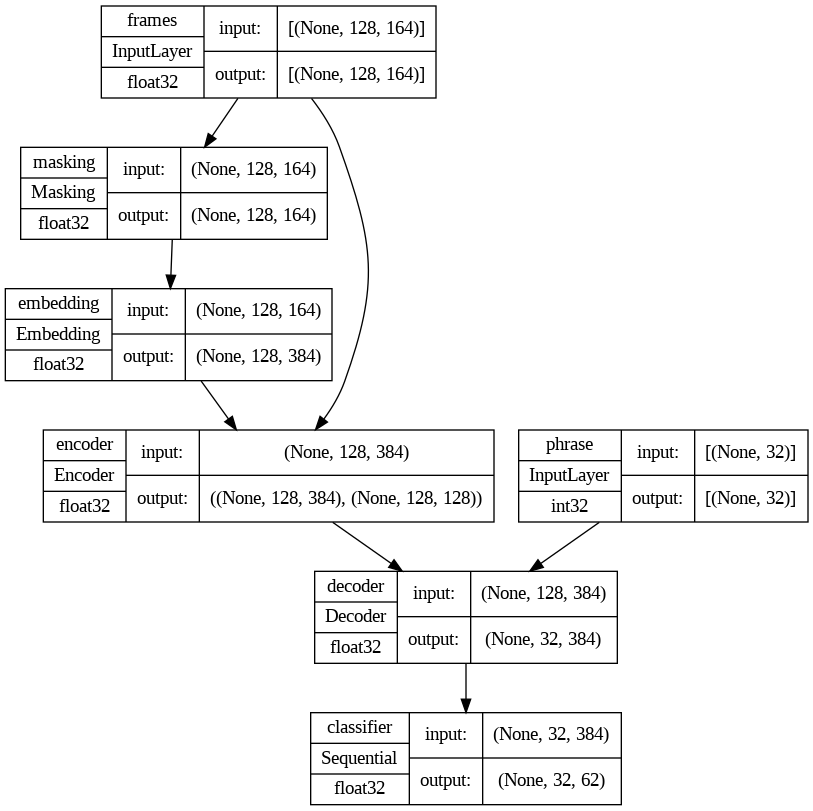

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True)